In [35]:
# Opening the JSON file
import json

# Specify the path to your JSON file
file_path = "C:\\Users\\palak\\Downloads\\Sarcasm_Headlines_Dataset.json"

# Load JSON data into a list of dictionaries
rows = []
with open(file_path, 'r') as file:
    for line in file:
        rows.append(json.loads(line))


In [36]:
#Suffling the data and splitting the data into training and test sets
import random
SPLIT_SIZE=0.9
suffled_set=random.sample(rows,len(rows))
train_length=int(len(suffled_set)*SPLIT_SIZE)
train_set=suffled_set[:train_length]
test_set=suffled_set[train_length:]

In [37]:
import pandas as pd

# Reading json files
df = pd.read_json('C:\\Users\\palak\\Downloads\\Sarcasm_Headlines_Dataset.json', lines=True)
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [38]:
#Data Summary
print('Total length of the dataset: ',len(suffled_set))
print('Length of the Training dataset: ',len(train_set))
print('Length of the Test dataset: ',len(test_set))

Total length of the dataset:  26709
Length of the Training dataset:  24038
Length of the Test dataset:  2671


In [39]:
#Data Format
train_set[1000]

{'article_link': 'https://www.huffingtonpost.com/entry/jenni-konner-lena-dunham_n_6426336.html',
 'headline': "'girls' producer: people are 'afraid' of lena dunham 'telling the truth'",
 'is_sarcastic': 0}

In [40]:
#This list is available at https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords=[ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [41]:
#Function to remove stopwords
def remove_stopwords(sentence):
  for word in stopwords:
    token=' '+word+' '
    sentence=sentence.replace(token,' ')
    sentence=sentence.replace('  ',' ')
  return sentence

In [42]:
#Function to get the plain text from the link of an article
def get_article(link):
  try:
    from bs4 import BeautifulSoup
    import urllib.request

    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'

    url = link

    headers={'User-Agent':user_agent,}

    request=urllib.request.Request(url,None,headers) #The assembled request
    response = urllib.request.urlopen(request)
    html= response.read()
    soup = BeautifulSoup(html)

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return ' '.join(text.split())
  except:
    return 'article not available'
    pass



In [43]:
#Function to separate the articles, headlines and labels from the data
def extract(array):

  #articles=[]
  headlines=[]
  labels=[]
  for i in range(len(array)):
    labels.append(array[i]['is_sarcastic'])
    headlines.append(remove_stopwords(array[i]['headline']))
    #articles.append(get_article(array[i]['article_link']))
  #return articles,headlines,labels
  return headlines,labels

In [44]:
pip install tensorflow

In [45]:
#import numpy as np
#headlines = np.array(headlines,dtype='float64')
#labels = np.array(labels, dtype ='float64')


In [46]:
#Extracting articles, headlines and labels from the data
import numpy as np
#train_articles,train_headlines,train_labels=extract(train_set)
train_headlines,train_labels=extract(train_set)
#test_articles,test_headlines,test_labels=extract(test_set)
test_headlines,test_labels=extract(test_set)


train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_headlines = np.array(train_headlines)
test_headlines = np.array(test_headlines)

In [47]:
#Preprocessing the training and test headlines for the word embedding
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_headlines)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_headlines)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_headlines)
test_padded = pad_sequences(test_sequences,maxlen=max_length)


# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

In [48]:
#Building the CNN Model
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


C:\Users\palak\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
# Add sample input data to the model
sample_input = np.random.randint(vocab_size, size=(1, max_length))

# Call the model on the sample input to build the model
_ = model_conv(sample_input)

# Compile the model
model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_conv.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (1, 118, 16)                │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (1, 59, 16)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 944)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 6)                      │           5,670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,461 (650.24 KB)

 Trainable params: 166,461 (650.24 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 20
history=model_conv.fit(padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels))


Epoch 1/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6191 - loss: 0.6224 - val_accuracy: 0.8180 - val_loss: 0.3983
Epoch 2/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8895 - loss: 0.2665 - val_accuracy: 0.8289 - val_loss: 0.3706
Epoch 3/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9476 - loss: 0.1486 - val_accuracy: 0.8311 - val_loss: 0.4264
Epoch 4/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9770 - loss: 0.0780 - val_accuracy: 0.8267 - val_loss: 0.5303
Epoch 5/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9886 - loss: 0.0410 - val_accuracy: 0.8210 - val_loss: 0.6290
Epoch 6/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9956 - loss: 0.0182 - val_accuracy: 0.8180 - val_loss: 0.7498
Epoch 7/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9986 - loss: 0.0088 - val_accuracy: 0.8136 - val_loss: 0.9037
Epoch 8/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.

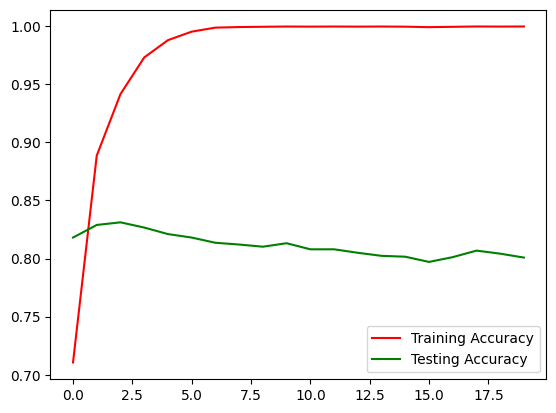

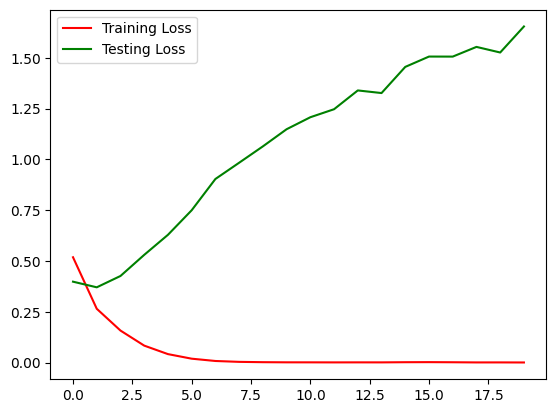

In [51]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

In [52]:
# Save CNN model
model_conv.save("cnn_model.h5")

In [53]:
from tensorflow.keras import regularizers

model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# **Bidirectional GATED RECURRENT UNIT (GRU)**

In [54]:
#Building the GRU Model
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [55]:
# Add sample input data to the model
sample_input = np.random.randint(vocab_size, size=(1, max_length))

# Call the model on the sample input to build the model
_ = model_gru(sample_input)

# Compile the model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 32)                     │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 6)                      │             198 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,469 (638.55 KB)

 Trainable params: 163,469 (638.55 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 20
history1=model_gru.fit(padded, train_labels, batch_size=1000,epochs=num_epochs, validation_data=(test_padded, test_labels))

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.5581 - loss: 0.6884 - val_accuracy: 0.5507 - val_loss: 0.6852
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.5600 - loss: 0.6790 - val_accuracy: 0.5507 - val_loss: 0.6614
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.5709 - loss: 0.6332 - val_accuracy: 0.7435 - val_loss: 0.5829
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.7655 - loss: 0.5430 - val_accuracy: 0.7364 - val_loss: 0.5650
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.7762 - loss: 0.5168 - val_accuracy: 0.7683 - val_loss: 0.4979
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.8182 - loss: 0.4281 - val_accuracy: 0.7791 - val_loss: 0.4629
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.8514 - loss: 0.3586 - val_accuracy: 0.7873 - val_loss: 0.4472
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.8752 - loss: 0.3042 - val_accuracy:

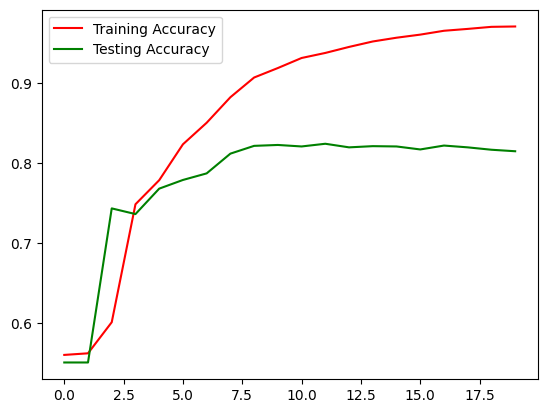

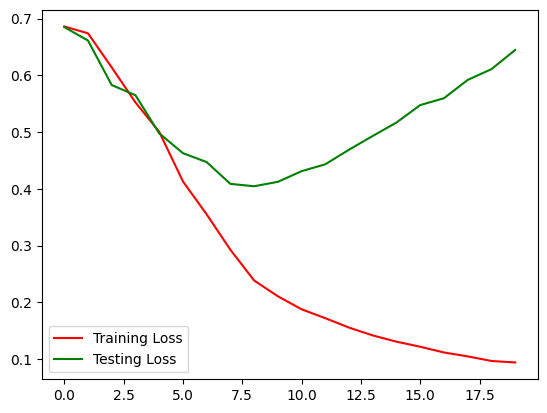

In [57]:
#Evaluating Accuracy anda Loss of the model
%matplotlib inline
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

In [58]:
import os
import tensorflow as tf

# Define the file name for the GRU model weights
gru_weights_file = 'model_gru_weights.weights.h5'

# Check if the file exists
if os.path.exists(gru_weights_file):
    # Remove the existing file
    os.remove(gru_weights_file)

# Save the GRU model weights using TensorFlow's built-in method
model_gru.save_weights(gru_weights_file)


# **Bidirectional LONG SHORT TERM MEMORY (LSTM)**

In [59]:
#Building the LSTM Model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [60]:
# Add sample input data to the model
sample_input = np.random.randint(vocab_size, size=(1, max_length))

# Call the model on the sample input to build the model
_ = model_lstm(sample_input)

# Summarize the model
model_lstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (1, 32)                     │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 6)                      │             198 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,429 (642.30 KB)

 Trainable params: 164,429 (642.30 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 20
history2=model_lstm.fit(padded, train_labels, batch_size=1000,epochs=num_epochs, validation_data=(test_padded, test_labels))

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.5481 - loss: 0.6874 - val_accuracy: 0.5507 - val_loss: 0.6784
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.5626 - loss: 0.6660 - val_accuracy: 0.5960 - val_loss: 0.6323
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.6892 - loss: 0.5898 - val_accuracy: 0.7888 - val_loss: 0.5320
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.8196 - loss: 0.4658 - val_accuracy: 0.7858 - val_loss: 0.4398
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8647 - loss: 0.3472 - val_accuracy: 0.7922 - val_loss: 0.4321
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.8870 - loss: 0.2879 - val_accuracy: 0.8237 - val_loss: 0.3839
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.9118 - loss: 0.2348 - val_accuracy: 0.8297 - val_loss: 0.3858
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.9267 - loss: 0.2020 - val_accuracy: 

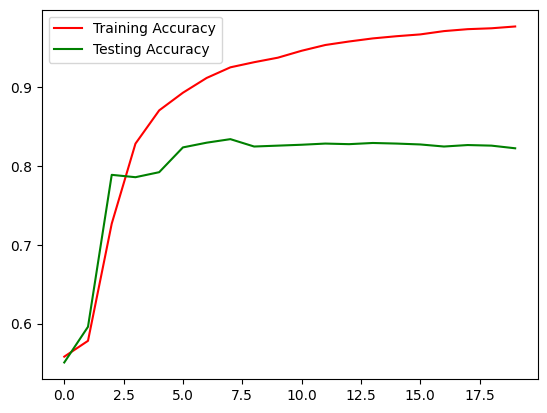

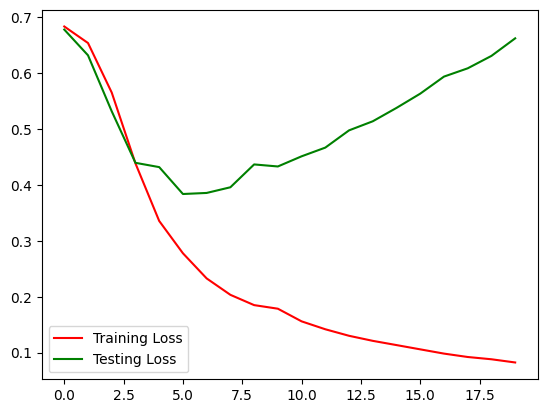

In [62]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

In [63]:
model_lstm.save("lstm_model.keras")  # Save the LSTM model with a different file name


In [64]:
import os

# Define the username
username = "palak"

# Define the base directory
base_dir = f'C:\\Users\\{username}\\Downloads'

# Check if the file exists in the base directory or any subdirectories
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.startswith("glove.6B") and file.endswith(".txt"):
            glove_file_path = os.path.join(root, file)
            break

# Check if the file was found
if 'glove_file_path' in locals():
    print("GloVe embeddings file found:", glove_file_path)
    # Proceed with loading the embeddings
    # Your code to load embeddings here
else:
    print("GloVe embeddings file not found.")


GloVe embeddings file found: C:\Users\palak\Downloads\glove.6B\glove.6B.100d.txt


In [65]:
import numpy as np

# Load the GloVe embeddings
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [66]:
import pickle

# Assuming tokenizer_obj is your tokenizer object
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [67]:
pip install imbalanced-learn


**DATA PREPROCESSING**

In [68]:
import pandas as pd

# Reading json files
df = pd.read_json('C:\\Users\\palak\\Downloads\\Sarcasm_Headlines_Dataset.json', lines=True)

In [69]:
data = df

In [70]:
data = df
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [71]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [72]:
import re


In [73]:
import string
import re  # Add this line
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

In [74]:
import matplotlib.pyplot as plt


(-0.5, 999.5, 499.5, -0.5)

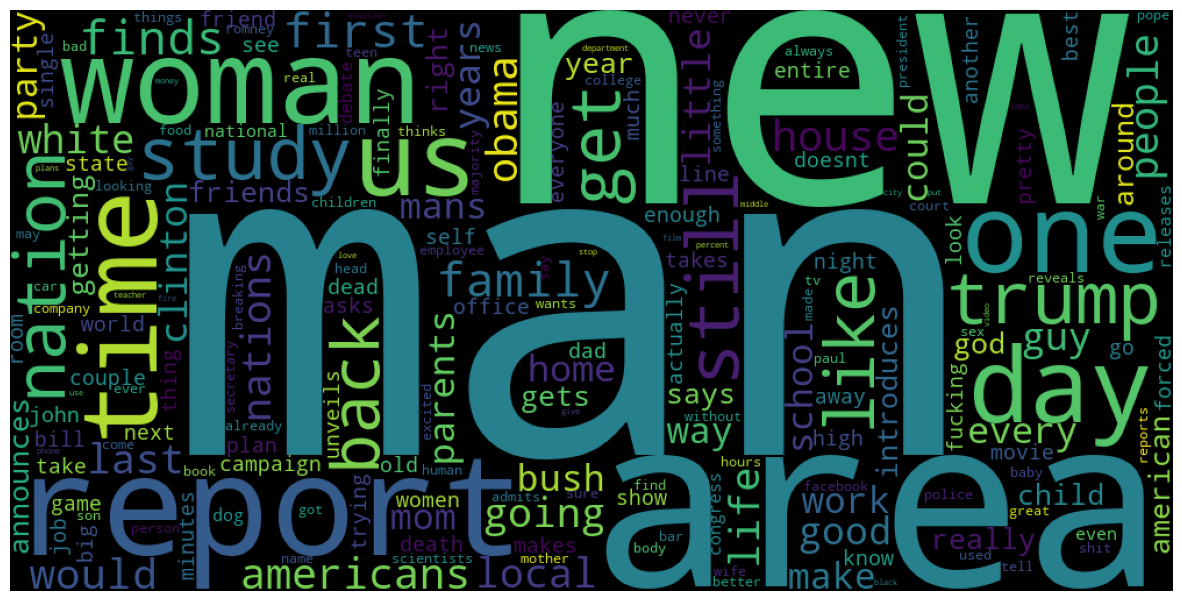

In [75]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt  # Add this line

pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict = Counter(pos_lines)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")


In [76]:
pip install wordcloud


In [77]:
import tensorflow as tf 
import keras as keras 
from tensorflow.keras.preprocessing.text import Tokenizer

In [78]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [79]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  27483
vocab size - 27484


In [80]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (21368, 25)
Shape of y_train: (21368,)
Shape of X_test_pad: (5341, 25)
Shape of y_test: (5341,)


In [81]:
import os

# Define the username
username = "palak"

# Define the base directory
base_dir = f'C:\\Users\\{username}\\Downloads'

# Check if the file exists in the base directory or any subdirectories
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.startswith("glove.6B") and file.endswith(".txt"):
            glove_file_path = os.path.join(root, file)
            break

# Check if the file was found
if 'glove_file_path' in locals():
    print("GloVe embeddings file found:", glove_file_path)
    # Proceed with loading the embeddings
    # Your code to load embeddings here
else:
    print("GloVe embeddings file not found.")


GloVe embeddings file found: C:\Users\palak\Downloads\glove.6B\glove.6B.100d.txt


In [91]:
import numpy as np

# Load the GloVe embeddings
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [94]:
import random

# Reduce dimensionality of GloVe embeddings to 16 by random sampling
reduced_embeddings_index = {}
for word, embedding_vector in embeddings_index.items():
    reduced_embedding_vector = random.sample(embedding_vector.tolist(), 16)
    reduced_embeddings_index[word] = np.array(reduced_embedding_vector)

# Initialize embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Populate embedding matrix
for word, i in word_index.items():
    embedding_vector = reduced_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('Embedding matrix shape:', embedding_matrix.shape)


Embedding matrix shape: (27484, 16)


In [95]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

C:\Users\palak\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Built the RNN Model**

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)

# Define the sequential model
model = Sequential()

# Add the layers to the model
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

# Call the model on a sample input to build it
sample_input = np.random.randint(vocab_size, size=(1, max_length))
_ = model(sample_input)

# Print the summary of the model
print('Summary of the built model...')
print(model.summary())


Summary of the built model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (1, 25, 16)                 │         439,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (1, 64)                     │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,545 (1.76 MB)

 Trainable params: 460,545 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

None


In [97]:
# Assuming padded, train_labels, and test_labels are defined and prepared correctly

# Define the padded sequences using pad_sequences function
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
num_epochs = 25
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)


Epoch 1/25
668/668 - 18s - 27ms/step - accuracy: 0.6506 - loss: 0.6166 - val_accuracy: 0.7798 - val_loss: 0.4678
Epoch 2/25
668/668 - 13s - 19ms/step - accuracy: 0.8526 - loss: 0.3691 - val_accuracy: 0.8015 - val_loss: 0.4314
Epoch 3/25
668/668 - 13s - 19ms/step - accuracy: 0.9156 - loss: 0.2374 - val_accuracy: 0.8042 - val_loss: 0.4696
Epoch 4/25
668/668 - 9s - 13ms/step - accuracy: 0.9431 - loss: 0.1693 - val_accuracy: 0.7993 - val_loss: 0.5064
Epoch 5/25
668/668 - 10s - 15ms/step - accuracy: 0.9597 - loss: 0.1292 - val_accuracy: 0.7918 - val_loss: 0.6264
Epoch 6/25
668/668 - 11s - 16ms/step - accuracy: 0.9689 - loss: 0.1078 - val_accuracy: 0.7911 - val_loss: 0.6837
Epoch 7/25
668/668 - 9s - 14ms/step - accuracy: 0.9763 - loss: 0.0819 - val_accuracy: 0.7892 - val_loss: 0.6621
Epoch 8/25
668/668 - 7s - 11ms/step - accuracy: 0.9804 - loss: 0.0685 - val_accuracy: 0.7837 - val_loss: 0.7688
Epoch 9/25
668/668 - 7s - 11ms/step - accuracy: 0.9832 - loss: 0.0594 - val_accuracy: 0.7791 - val_

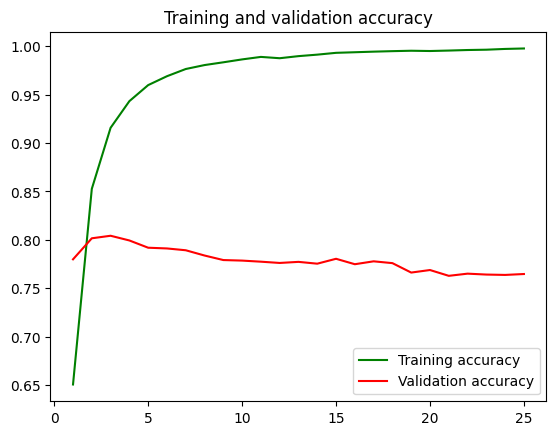

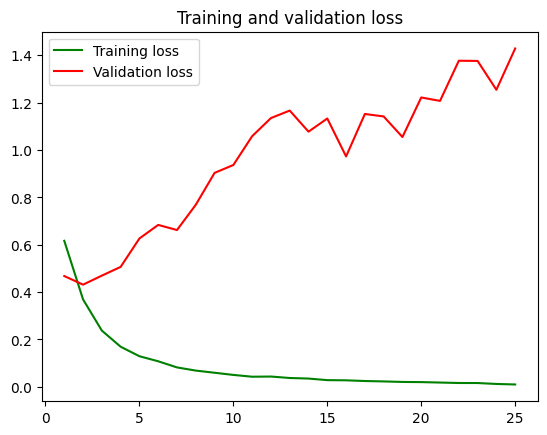

In [98]:
# Plot results
acc = history.history['accuracy']  # Use 'accuracy' instead of 'acc'
val_acc = history.history['val_accuracy']  # Use 'val_accuracy' instead of 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [99]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [100]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


"It's a sarcasm!"

In [101]:
predict_sarcasm("You just broke my car window. Great job.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


"It's not a sarcasm."

In [102]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


"It's not a sarcasm."

In [103]:
predict_sarcasm("I want a million dollars!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


"It's not a sarcasm."

In [104]:
predict_sarcasm("former versace store clerk sues over secret 'black code' for minority shoppers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


"It's not a sarcasm."

In [105]:
predict_sarcasm("top snake handler leaves sinking huckabee campaign")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


"It's a sarcasm!"

In [106]:
predict_sarcasm("adorable animated hunchback to shove self down area throats")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


"It's a sarcasm!"

In [107]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and obtained predictions
# Replace y_pred with your actual predictions
y_pred = model.predict(X_test_pad)

# Assuming y_test contains the true labels for the test set

# Convert predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_labels))


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3024
           1       0.75      0.68      0.72      2317

    accuracy                           0.76      5341
   macro avg       0.76      0.75      0.76      5341
weighted avg       0.76      0.76      0.76      5341



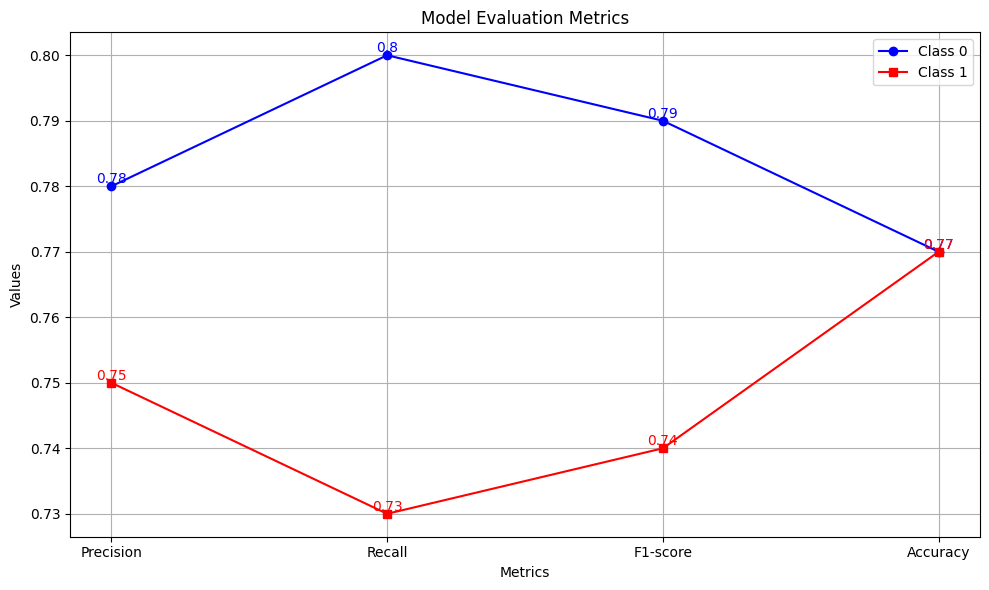

In [108]:
import matplotlib.pyplot as plt

# Define the metrics and their corresponding values
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
values_class_0 = [0.78, 0.80, 0.79, 0.77]  # Replace with precision, recall, F1-score, and accuracy for class 0
values_class_1 = [0.75, 0.73, 0.74, 0.77]  # Replace with precision, recall, F1-score, and accuracy for class 1

# Plot the evaluation metrics for class 0
plt.figure(figsize=(10, 6))
plt.plot(metrics, values_class_0, marker='o', color='blue', linestyle='-', label='Class 0')

# Annotate the points with their values for class 0
for i, val in enumerate(values_class_0):
    plt.text(metrics[i], val, f'{val}', va='bottom', ha='center', color='blue')

# Plot the evaluation metrics for class 1
plt.plot(metrics, values_class_1, marker='s', color='red', linestyle='-', label='Class 1')

# Annotate the points with their values for class 1
for i, val in enumerate(values_class_1):
    plt.text(metrics[i], val, f'{val}', va='bottom', ha='center', color='red')

plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assuming vocab_size, embedding_dim, max_length, X_train_pad, y_train, X_test_pad, y_test are defined

# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)

# Define the sequential model
model = Sequential()

# Add the layers to the model
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a validation split
num_epochs = 25
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=num_epochs, validation_split=0.2, verbose=2)


Epoch 1/25


C:\Users\palak\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


535/535 - 10s - 18ms/step - accuracy: 0.6821 - loss: 0.5904 - val_accuracy: 0.7714 - val_loss: 0.4859
Epoch 2/25
535/535 - 6s - 11ms/step - accuracy: 0.8676 - loss: 0.3436 - val_accuracy: 0.7939 - val_loss: 0.4832
Epoch 3/25
535/535 - 8s - 14ms/step - accuracy: 0.9283 - loss: 0.2131 - val_accuracy: 0.7871 - val_loss: 0.5524
Epoch 4/25
535/535 - 7s - 13ms/step - accuracy: 0.9527 - loss: 0.1494 - val_accuracy: 0.7815 - val_loss: 0.5775
Epoch 5/25
535/535 - 4s - 8ms/step - accuracy: 0.9661 - loss: 0.1127 - val_accuracy: 0.7817 - val_loss: 0.6107
Epoch 6/25
535/535 - 7s - 13ms/step - accuracy: 0.9758 - loss: 0.0873 - val_accuracy: 0.7822 - val_loss: 0.6998
Epoch 7/25
535/535 - 9s - 16ms/step - accuracy: 0.9794 - loss: 0.0713 - val_accuracy: 0.7840 - val_loss: 0.7798
Epoch 8/25
535/535 - 7s - 13ms/step - accuracy: 0.9837 - loss: 0.0607 - val_accuracy: 0.7773 - val_loss: 0.7036
Epoch 9/25
535/535 - 7s - 13ms/step - accuracy: 0.9860 - loss: 0.0537 - val_accuracy: 0.7723 - val_loss: 0.8176
Epo